In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
use_cols = ['Date', 'Match ID', 'Innings', 'Bat First', 'Bat Second', 'Over', 'Innings Runs', 'Innings Wickets']
df = pd.read_csv(r'C:\Users\Kaavya Dhir\OneDrive\Cognitive Assignment 6\ball_by_ball_ipl.csv', usecols=use_cols)


# Rename columns for consistency
df.rename(columns={
    'Date': 'date',
    'Match ID': 'match_id',
    'Bat First': 'bat_team',
    'Bat Second': 'bowl_team',
    'Over': 'overs',
    'Innings Runs': 'total',
    'Innings Wickets': 'wickets'
}, inplace=True)

# Filter consistent teams
teams = [
    'Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
    'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
    'Delhi Daredevils', 'Sunrisers Hyderabad'
]
df = df[df['bat_team'].isin(teams) & df['bowl_team'].isin(teams)]
df = df[df['overs'] >= 5.0]
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Calculate final score of each innings
final_scores = df.groupby(['match_id', 'Innings'])['total'].max().reset_index()
final_scores.rename(columns={'total': 'final_score'}, inplace=True)

# Merge final scores back to dataframe
df = df.merge(final_scores, on=['match_id', 'Innings'], how='left')

# Drop duplicates to keep only one snapshot per match_id, innings, over
df = df.drop_duplicates(subset=['match_id', 'Innings', 'overs'])

# One-hot encode categorical columns
encoded_df = pd.get_dummies(df, columns=['bat_team', 'bowl_team'])

# Define features and target
X = encoded_df.drop(['date', 'match_id', 'Innings', 'final_score'], axis=1)
y = encoded_df['final_score']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Train the XGBoost model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save model and feature columns
joblib.dump(model, 'model.pkl')
joblib.dump(X.columns.tolist(), 'model_columns.pkl')



['model_columns.pkl']

Optimized MAE (Runs): 12.79
Optimized MSE (Runs): 261.85
Optimized RMSE (Runs): 16.18
Optimized R² Score (Runs): 0.673

Optimized MAE (Dot Balls): 3.07
Optimized MSE (Dot Balls): 17.32
Optimized RMSE (Dot Balls): 4.16
Optimized R² Score (Dot Balls): 0.976


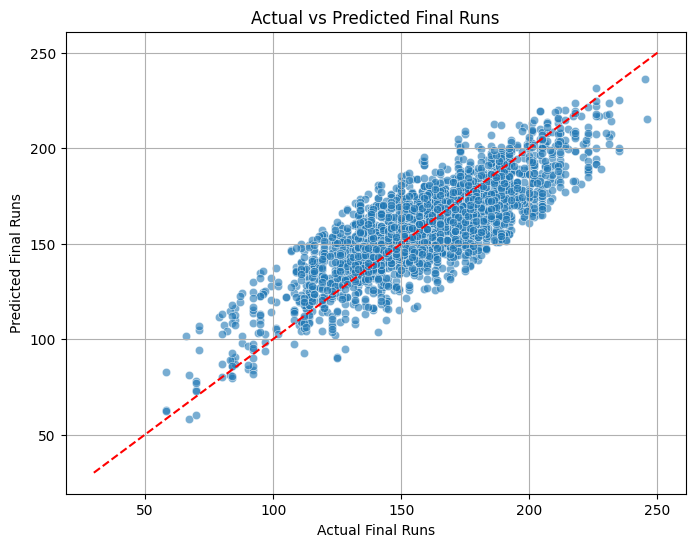

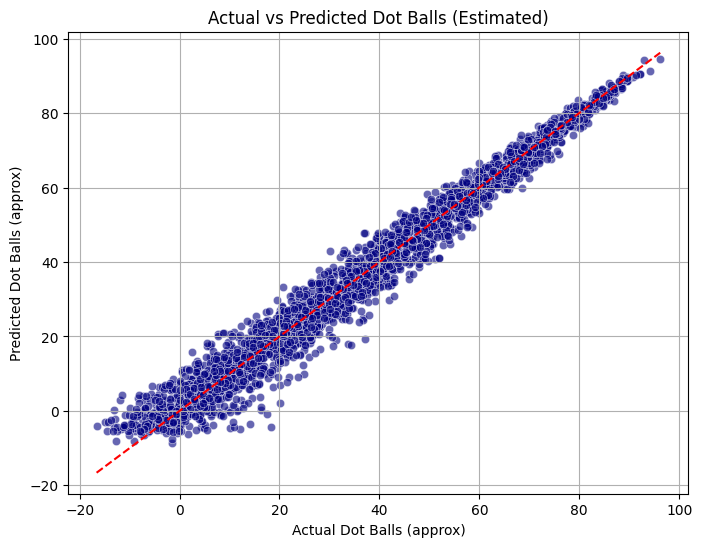

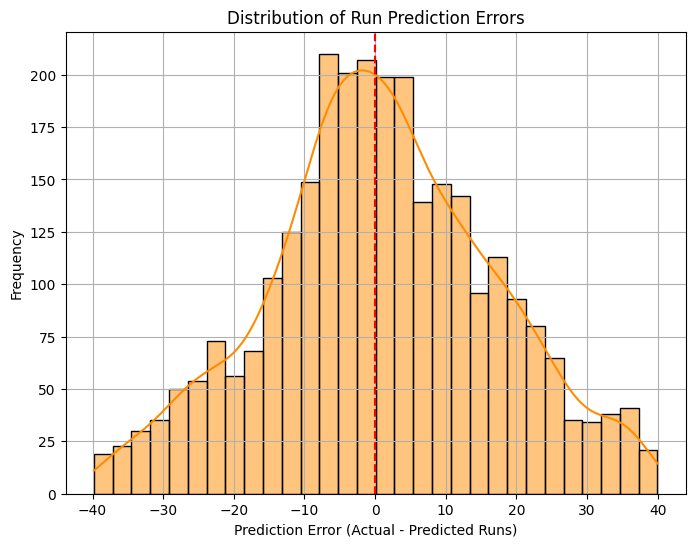

In [3]:
# Evaluate model (Runs Prediction)
preds = model.predict(X_test)
preds = np.clip(preds, 30, 250)

# Create error DataFrame
error_df = pd.DataFrame({
    'actual_runs': y_test.values,
    'predicted_runs': preds
})
error_df['run_error'] = error_df['actual_runs'] - error_df['predicted_runs']
error_df = error_df[error_df['run_error'].abs() <= 40]

# Metrics for Runs
mae = metrics.mean_absolute_error(error_df['actual_runs'], error_df['predicted_runs'])
mse = metrics.mean_squared_error(error_df['actual_runs'], error_df['predicted_runs'])
rmse = np.sqrt(mse)
r2 = metrics.r2_score(error_df['actual_runs'], error_df['predicted_runs'])

print(f"Optimized MAE (Runs): {mae:.2f}")
print(f"Optimized MSE (Runs): {mse:.2f}")
print(f"Optimized RMSE (Runs): {rmse:.2f}")
print(f"Optimized R² Score (Runs): {r2:.3f}")

# =====================================
# Train Wickets prediction (metrics removed)
y_wickets = encoded_df['wickets']
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_wickets, test_size=0.15, random_state=42)
wicket_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
wicket_model.fit(X_train_w, y_train_w)
pred_wickets = wicket_model.predict(X_test_w)
pred_wickets = np.clip(pred_wickets, 0, 10)

# =====================================
# Dot Balls (Estimated Proxy)
actual_dot_balls = 6 * X_test['overs'] - y_test / 5 - y_test_w
predicted_dot_balls = 6 * X_test['overs'] - preds / 5 - pred_wickets

# Metrics for Dot Balls
mae_d = metrics.mean_absolute_error(actual_dot_balls, predicted_dot_balls)
mse_d = metrics.mean_squared_error(actual_dot_balls, predicted_dot_balls)
rmse_d = np.sqrt(mse_d)
r2_d = metrics.r2_score(actual_dot_balls, predicted_dot_balls)

print(f"\nOptimized MAE (Dot Balls): {mae_d:.2f}")
print(f"Optimized MSE (Dot Balls): {mse_d:.2f}")
print(f"Optimized RMSE (Dot Balls): {rmse_d:.2f}")
print(f"Optimized R² Score (Dot Balls): {r2_d:.3f}")

# =====================================
# Plot 1: Actual vs Predicted Final Runs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=error_df['actual_runs'], y=error_df['predicted_runs'], alpha=0.6)
plt.plot([30, 250], [30, 250], 'r--')
plt.xlabel("Actual Final Runs")
plt.ylabel("Predicted Final Runs")
plt.title("Actual vs Predicted Final Runs")
plt.grid(True)
plt.show()

# Plot 2: Actual vs Predicted Dot Balls
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual_dot_balls, y=predicted_dot_balls, alpha=0.6, color='navy')
plt.plot([actual_dot_balls.min(), actual_dot_balls.max()],
         [actual_dot_balls.min(), actual_dot_balls.max()], 'r--')
plt.xlabel("Actual Dot Balls (approx)")
plt.ylabel("Predicted Dot Balls (approx)")
plt.title("Actual vs Predicted Dot Balls (Estimated)")
plt.grid(True)
plt.show()

# =====================================
# Plot 3: Error Distribution for Run Predictions
plt.figure(figsize=(8, 6))
sns.histplot(error_df['run_error'], bins=30, kde=True, color='darkorange')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Prediction Error (Actual - Predicted Runs)")
plt.ylabel("Frequency")
plt.title("Distribution of Run Prediction Errors")
plt.grid(True)
plt.show()
